In [9]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from collections import defaultdict
import plotly.graph_objs as go

In [10]:

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    additional_stop_words = {"dog", "said", "fish","us","mr"} 
    stop_words.update(additional_stop_words)
    tokens = [word for word in tokens if word not in stop_words]
    # Combine tokens back into a single string
    return " ".join(tokens)


In [11]:
# Ladda ner NLTK-resurser
nltk.download("punkt")
nltk.download("stopwords")

# Läs in datasetet
data = pd.read_csv("TNM098-MC3-2011.csv", delimiter=";")

# Förbehandla innehållet i Content-kolumnen
data["Processed_Content"] = data["Content"].apply(preprocess_text)

# Definiera en lista med relevanta nyckelord
relevant_keywords = ["threat", "terrorism", "dead", "attack", "explosion", "bomb", "dangerous","airlines","police"]

# Filtrera datasetet baserat på nyckelorden i Processed_Content-kolumnen
filtered_data = data[data["Processed_Content"].str.contains("|".join(relevant_keywords))]

# Visa den filtrerade datasetet
# print(filtered_data.head())

# Skriv ut de fem första hela texterna
for index, row in filtered_data.head().iterrows():
    print("Hela texten för rapport", index + 1, ":")
    print(row["Content"])
    print("---------------------------------------------------------")



Hela texten för rapport 1 :
A group called Citizens for the Ethical Treatment of Lab Mice, believed by city officials to be connected to the Brotherhood of Antarctica, has been sending emails of a threatening nature to VastPress. It seems they are upset with the experiments applied to mice. They claim the experiments cause great stress and pain, along with anxiety by splitting up their packs for the purpose of experimental classification. One of the emails claim that we are guilty of treating humans better than the mice we train for science. We would like to pursue this thought but are unsure how to contact the leader in the group. The threats are rather strange, with the intent to ``free'' all mice in the city and use humans for experimental purposes.
---------------------------------------------------------
Hela texten för rapport 2 :
VastPress has recently received numerous threatening emails. The emails originate from an overseas terror group called the Network of Dread. The Networ

[nltk_data] Downloading package punkt to C:\Users\Vilma
[nltk_data]     Lundholm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Vilma
[nltk_data]     Lundholm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


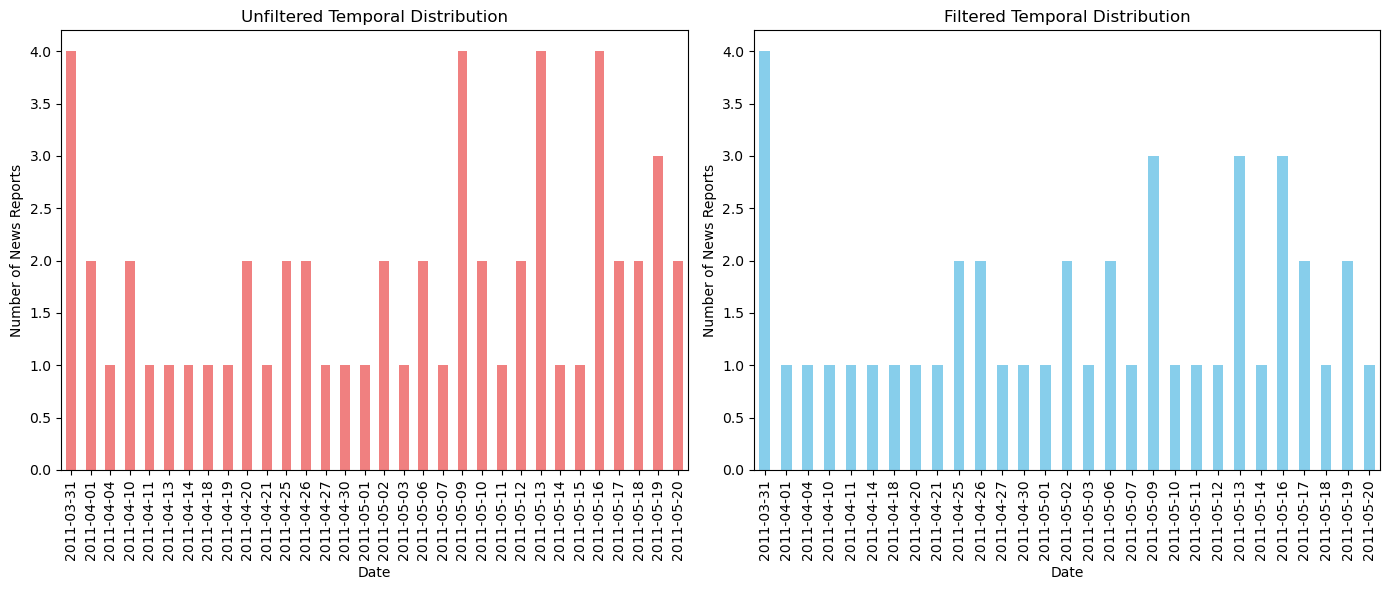

In [12]:
# Group by date and count the number of news reports for each date for both datasets
daily_counts_unfiltered = data.groupby(data['Date']).size()
daily_counts_filtered = pd.to_datetime(filtered_data['Date'])

# Gruppera efter datum och räkna antalet nyhetsrapporter för varje dag
daily_counts_filtered = filtered_data.groupby('Date').size()

# Plot the histograms side by side
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
daily_counts_unfiltered.plot(kind='bar', color='lightcoral')
plt.title('Unfiltered Temporal Distribution')
plt.xlabel('Date')
plt.ylabel('Number of News Reports')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
daily_counts_filtered.plot(kind='bar', color='skyblue')
plt.title('Filtered Temporal Distribution')
plt.xlabel('Date')
plt.ylabel('Number of News Reports')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [13]:
# Displaya ämnesrelaterade ord
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print("Top words:", end=' ')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print()


# Visualisera ämnen med WordCloud
def visualize_topics(model, feature_names, num_top_words):
    wordcloud_array=[]
    for topic_idx, topic in enumerate(model.components_):
        word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-num_top_words - 1:-1]}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        wordcloud_array.append(wordcloud)
        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {topic_idx + 1} Word Cloud')
        plt.show()
    return wordcloud_array


Ämnen hittade via LDA:
Topic 1:
Top words: turman, patino, radioactive, report, professor, university, exercises, department, mayor, equipment

Topic 2:
Top words: investigators, crash, festival, source, stanley, police, officials, evidence, games, french

Topic 3:
Top words: mascot, police, man, team, damron, commission, old, systems, release, classified

Topic 4:
Top words: police, weapons, turkey, airlines, truck, antarctica, mice, city, food, flight

Topic 5:
Top words: games, obryan, thom, threats, mayor, press, dead, vast, officials, reported



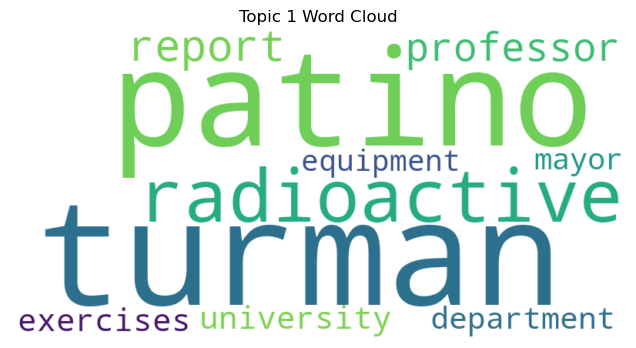

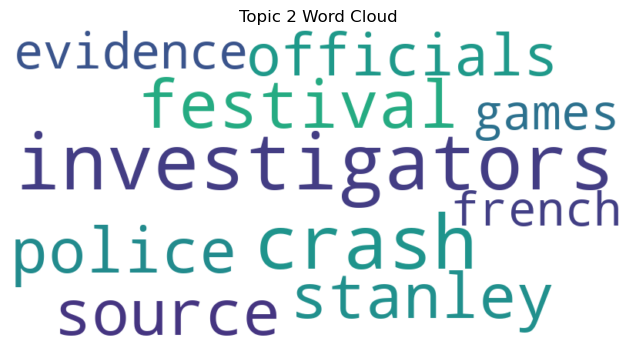

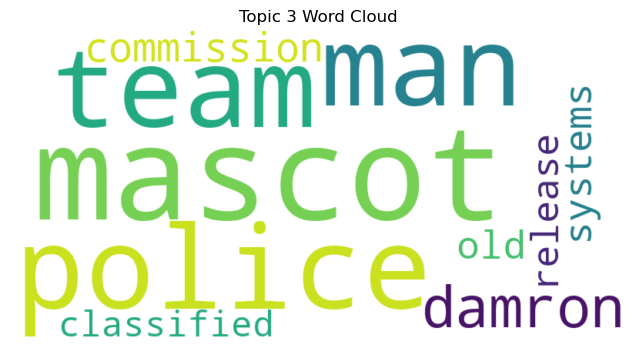

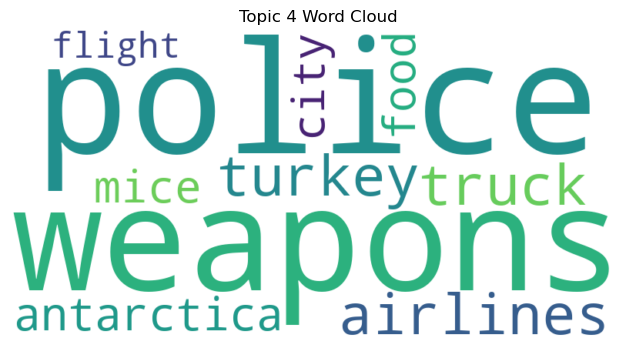

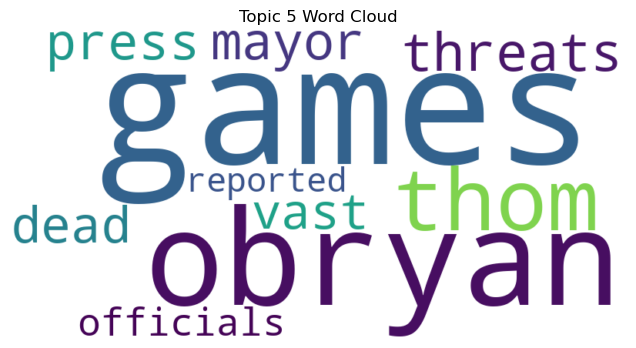

In [14]:
# Skapa en TF-IDF-matris
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_data['Processed_Content'])

# Bygg LDA-modell
num_topics = 5  
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(tfidf_matrix)


# Skriv ut ämnena och relaterade ord
print("Ämnen hittade via LDA:")
num_top_words = 10  
feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, num_top_words)


# Visualisera ämnen med WordCloud
wordcloud_array = visualize_topics(lda_model, feature_names, num_top_words)


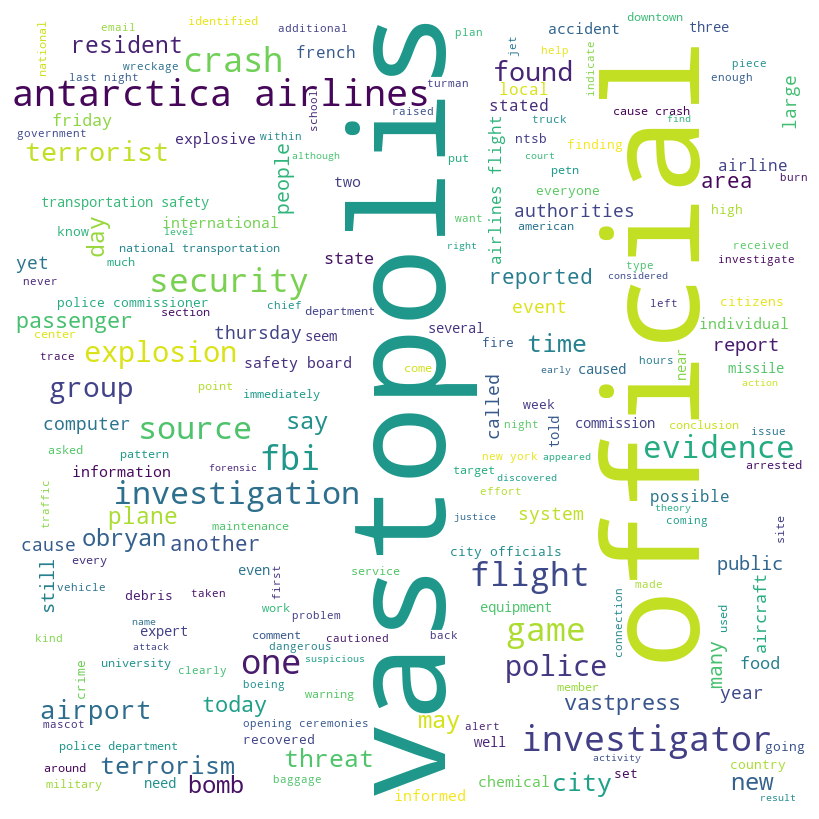

In [15]:
all_words = " ".join(data['Processed_Content'])

# Skapa en wordcloud med alla ord
wordcloud_fulldataset = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(all_words)

# Plotta wordcloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_fulldataset) 
plt.axis("off")
plt.tight_layout(pad = 0) 

plt.show() 

In [16]:

# Skapa en defaultdict för att lagra frekvensen av varje ord per datum för varje ämne
topic_word_freq_by_date_filtered = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
topic_word_freq_by_date_unfiltered = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

# Loopa igenom varje ämne och dess relaterade ord
for topic_idx, topic in enumerate(lda_model.components_):

    #print(f"Topic {topic_idx + 1}:")

    for word_idx in topic.argsort()[:-num_top_words - 1:-1]:
        word = feature_names[word_idx]
        #print(f"- {word}")

        # Loopa igenom det filtrerade datasetet för att matcha ord med deras timestamps och räkna frekvenser
        for _, row in filtered_data.iterrows():
            content = row["Processed_Content"]
            date = row["Date"]
            if word in content:
                topic_word_freq_by_date_filtered[topic_idx][word][date] += 1

        # Loopa igenom det ofiltrerade datasetet för att matcha ord med deras timestamps och räkna frekvenser
        for _, row in data.iterrows():
            content = row["Processed_Content"]
            date = row["Date"]
            if word in content:
                topic_word_freq_by_date_unfiltered[topic_idx][word][date] += 1

layout = go.Layout(
    yaxis=dict(title='Frequency'),
    barmode='group',
    hovermode='closest',
    width=1000,
    height=500
)

# Loopa igenom varje ämne
for topic_idx, (word_freq_by_date_filtered, word_freq_by_date_unfiltered) in enumerate(zip(topic_word_freq_by_date_filtered.values(), topic_word_freq_by_date_unfiltered.values())):

    #skapar två litor 
    date_filtered = []
    date_unfiltered=[]

    # Yttre loop: Loopa över varje dictionary (word_freq) i word_freq_by_date_filtered.values() vilket är alla datum för varje ord
    for date_freq in word_freq_by_date_filtered.values():
    # Inre loop: Date_freq består av datum så nycklar är datumen, här loopas allt igenom för den aktuella dictionaryn
        for date in date_freq.keys():
            date_filtered.append(date)

    # Ta bort duplicerade datumen och sortera dem i stigande ordning
    dates_filtered = sorted(set(date_filtered))

    #Samma sak som för filterd
    for word_freq in word_freq_by_date_unfiltered.values():
        for date in word_freq.keys():
            date_unfiltered.append(date)

    dates_unfiltered = sorted(set(date_unfiltered))
    
    #på word_freq_by_date_filtered är varje nyckel ett ord (struktur: {"ord1": {"datum1": frekvens1, "datum2": frekvens2, ...}, "ord2":..} )
    #listar dessa i ny variabel
    words_to_plot_filtered = sorted( list(word_freq_by_date_filtered.keys()))
    words_to_plot_unfiltered = sorted(list(word_freq_by_date_unfiltered.keys()))

    # Skapa stapeldiagrams för det filtrerade datasetet
    traces_filtered = []
  
    for word_to_plot in words_to_plot_filtered:
        #Hämtar frekvensen för ett spefikt ord för ett datum, om ordet inte finns för datumemt sätt frekvensent till 0
        frequencies = [word_freq_by_date_filtered[word_to_plot].get(date, 0) for date in dates_filtered]
        trace = go.Bar(x=dates_filtered, y=frequencies, name=word_to_plot)
        traces_filtered.append(trace)

    # Skapa stapeldiagram för det ofiltrerade datasetet
    traces_unfiltered = []

    for word_to_plot in words_to_plot_unfiltered:
        frequencies = [word_freq_by_date_unfiltered[word_to_plot].get(date, 0) for date in dates_unfiltered]
        trace = go.Bar(x=dates_unfiltered, y=frequencies, name=word_to_plot)
        traces_unfiltered.append(trace)

    # Skapa figurobjekt för det filtrerade datasetet
    fig_filtered = go.Figure(data=traces_filtered, layout=layout)
    fig_filtered.update_layout(title=f"Filtered Data - Topic {topic_idx + 1}")

    # Skapa figurobjekt för det ofiltrerade datasetet
    fig_unfiltered = go.Figure(data=traces_unfiltered, layout=layout)
    fig_unfiltered.update_layout(title=f"Unfiltered Data - Topic {topic_idx + 1}")

    # Visa stapeldiagrammen bredvid varandra
    fig_filtered.show()
    fig_unfiltered.show()
